In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import os
import matplotlib.pyplot as plt
import joblib
from copy import deepcopy
import numpy as np
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from sklearn import feature_selection
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import pandas as pd
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
import random
random_state = 42
import tempfile


In [3]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os 
COMET=1
# Create an experiment with your api key
if COMET:
    comet_exp = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),  # don’t hardcode!!
        project_name="milestone_2",
        workspace="morph-e",
        log_code=True,
    )

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/c8ebe3904da1468ea9e239c6b86569c8



In [4]:
### Script to get the DataFrame and Split the data into train and test set for FE1
years = [2015,2016,2017,2018]
dataset = SeasonDataSetTwo(years)
df_total = dataset.get_features_2()
df = df_total[df_total['gamePk'].astype(str).str[5]=='2'].reset_index(drop=True)##Filtering only for regular dataframe

File already Exists, loading from ../ift6758/data/PICKLE//2015_2016_2017_2018_features2.pkl


In [5]:
df["Year"]=[str(x)[:4] for x in df['gamePk']]
df["Year"] =df["Year"].astype('int')
df.head()
df

,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,isHome,gameSeconds,totalGameSeconds,...,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,Year
0,2015020001,Toronto Maple Leafs,1,-55.0,6.0,Wrist Shot,0,True,51.0,51.0,...,Hit,94.0,-34.0,11.0,154.275727,False,14.025066,0.000000,0.000000,2015
1,2015020001,Toronto Maple Leafs,1,-79.0,0.0,Snap Shot,0,True,65.0,65.0,...,Giveaway,-37.0,-28.0,7.0,50.477718,False,7.211103,0.000000,0.000000,2015
2,2015020001,Toronto Maple Leafs,1,-75.0,-1.0,Snap Shot,0,True,66.0,66.0,...,Shot,-79.0,0.0,1.0,4.123106,True,4.123106,4.085617,4.085617,2015
3,2015020001,Toronto Maple Leafs,1,-55.0,-36.0,Wrist Shot,0,True,113.0,113.0,...,Hit,-91.0,35.0,18.0,79.605276,False,4.422515,0.000000,0.000000,2015
4,2015020001,Toronto Maple Leafs,1,-61.0,-1.0,Tip-In,0,True,157.0,157.0,...,Faceoff,-69.0,-22.0,5.0,22.472205,False,4.494441,0.000000,0.000000,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311101,2018021271,San Jose Sharks,3,67.0,-19.0,Slap Shot,0,True,937.0,3337.0,...,Giveaway,29.0,35.0,33.0,66.030296,False,2.000918,0.000000,0.000000,2018
311102,2018021271,Colorado Avalanche,3,-78.0,1.0,Wrist Shot,0,False,993.0,3393.0,...,Faceoff,-69.0,-22.0,29.0,24.698178,False,0.851661,0.000000,0.000000,2018
311103,2018021271,Colorado Avalanche,3,-82.0,10.0,Wrist Shot,0,False,1119.0,3519.0,...,Missed Shot,-71.0,4.0,19.0,12.529964,False,0.659472,0.000000,0.000000,2018
311104,2018021271,Colorado Avalanche,3,-81.0,1.0,Wrist Shot,0,False,1120.0,3520.0,...,Shot,-82.0,10.0,1.0,9.055385,True,9.055385,47.882963,47.882963,2018


In [6]:
df["emptyNet"] = df["emptyNet"].astype("int")

* Random Forests
* XGBoost with Yearwise Validation
* Kfold CV
* EarlyStopping
* XGBoost Over Sampling
* Removing where emptynet is True events
* Strength in OverTime
* L1,L2 reguraliser

In [7]:
df

,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,isHome,gameSeconds,totalGameSeconds,...,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,Year
0,2015020001,Toronto Maple Leafs,1,-55.0,6.0,Wrist Shot,0,True,51.0,51.0,...,Hit,94.0,-34.0,11.0,154.275727,False,14.025066,0.000000,0.000000,2015
1,2015020001,Toronto Maple Leafs,1,-79.0,0.0,Snap Shot,0,True,65.0,65.0,...,Giveaway,-37.0,-28.0,7.0,50.477718,False,7.211103,0.000000,0.000000,2015
2,2015020001,Toronto Maple Leafs,1,-75.0,-1.0,Snap Shot,0,True,66.0,66.0,...,Shot,-79.0,0.0,1.0,4.123106,True,4.123106,4.085617,4.085617,2015
3,2015020001,Toronto Maple Leafs,1,-55.0,-36.0,Wrist Shot,0,True,113.0,113.0,...,Hit,-91.0,35.0,18.0,79.605276,False,4.422515,0.000000,0.000000,2015
4,2015020001,Toronto Maple Leafs,1,-61.0,-1.0,Tip-In,0,True,157.0,157.0,...,Faceoff,-69.0,-22.0,5.0,22.472205,False,4.494441,0.000000,0.000000,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311101,2018021271,San Jose Sharks,3,67.0,-19.0,Slap Shot,0,True,937.0,3337.0,...,Giveaway,29.0,35.0,33.0,66.030296,False,2.000918,0.000000,0.000000,2018
311102,2018021271,Colorado Avalanche,3,-78.0,1.0,Wrist Shot,0,False,993.0,3393.0,...,Faceoff,-69.0,-22.0,29.0,24.698178,False,0.851661,0.000000,0.000000,2018
311103,2018021271,Colorado Avalanche,3,-82.0,10.0,Wrist Shot,0,False,1119.0,3519.0,...,Missed Shot,-71.0,4.0,19.0,12.529964,False,0.659472,0.000000,0.000000,2018
311104,2018021271,Colorado Avalanche,3,-81.0,1.0,Wrist Shot,0,False,1120.0,3520.0,...,Shot,-82.0,10.0,1.0,9.055385,True,9.055385,47.882963,47.882963,2018


In [8]:
df.dtypes

gamePk                    object
team.name                 object
gamePeriod                 int64
coordinatesX             float64
coordinatesY             float64
shotType                  object
emptyNet                   int32
isHome                    object
gameSeconds              float64
totalGameSeconds         float64
shotDistance             float64
shotAngle                float64
isGoal                     int64
lastEventType             object
lastEventCoordinatesX    float64
lastEventCoordinatesY    float64
timeFromLastEvent        float64
distanceFromLastEvent    float64
rebound                     bool
speed                    float64
changeInShotAngle        float64
angleSpeed               float64
Year                       int32
dtype: object

## XGBoost Yearwise Validation + EmptyNet: False in Train, No EmptyNet

In [9]:
features = ['gameSeconds','totalGameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','isHome','coordinatesX','coordinatesY', 'shotDistance','lastEventType','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle','emptyNet',"Year"]
label = ['isGoal']

In [10]:
df_exp = df[features+label]
print(df_exp.isna().any())
df_exp.head()


gameSeconds              False
totalGameSeconds         False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
isHome                    True
coordinatesX              True
coordinatesY              True
shotDistance              True
lastEventType            False
lastEventCoordinatesX     True
lastEventCoordinatesY     True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle         True
emptyNet                 False
Year                     False
isGoal                   False
dtype: bool


,gameSeconds,totalGameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,isHome,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,emptyNet,Year,isGoal
0,51.0,51.0,11.0,1,Wrist Shot,10.007980,True,-55.0,6.0,34.525353,Hit,94.0,-34.0,154.275727,False,14.025066,0.000000,0,2015,0
1,65.0,65.0,7.0,1,Snap Shot,0.000000,True,-79.0,0.0,10.000000,Giveaway,-37.0,-28.0,50.477718,False,7.211103,0.000000,0,2015,0
2,66.0,66.0,1.0,1,Snap Shot,-4.085617,True,-75.0,-1.0,14.035669,Shot,-79.0,0.0,4.123106,True,4.123106,4.085617,0,2015,0
3,113.0,113.0,18.0,1,Wrist Shot,-46.636577,True,-55.0,-36.0,49.517674,Hit,-91.0,35.0,79.605276,False,4.422515,0.000000,0,2015,0
4,157.0,157.0,5.0,1,Tip-In,-2.045408,True,-61.0,-1.0,28.017851,Faceoff,-69.0,-22.0,22.472205,False,4.494441,0.000000,0,2015,0


In [11]:
## Removing nan and inf data of features 

remove_nan_inf_features= ["shotAngle","coordinatesX","coordinatesY","shotDistance","lastEventCoordinatesX","lastEventCoordinatesY","distanceFromLastEvent","speed","changeInShotAngle"]
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_exp["changeInShotAngle"].replace(0,np.nan,inplace=True)


## Converting category features to Category Types
categories = ['shotType','gamePeriod','lastEventType','rebound','isHome']
df_exp[categories]=df_exp[categories].astype("category")


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [12]:
features = ['gameSeconds','totalGameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','isHome','coordinatesX','coordinatesY', 'shotDistance','lastEventType','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [13]:
dfTrain = df_exp[df_exp["Year"].isin([2015,2016,2017])]
dfVal = df_exp[df_exp["Year"].isin([2018])]
Xtrain = dfTrain[features]
Ytrain = dfTrain[label]
Xval = dfVal[features]
Yval = dfVal[label]


In [14]:
predscore_val_dict={}

weights_dir = "../ift6758/models/weights/"

In [15]:
experiment = "xgb-base"
#obtaining default parameters by calling .fit() to XGBoost model instance
estimator = xgb.XGBClassifier(objective='binary:logistic',
                         enable_categorical=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                        )
estimator.fit(Xtrain, Ytrain.values.flatten())
y_pred_val  = estimator.predict(Xval)
y_pred_val_scores = estimator.predict_proba(Xval)[:,1]


predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores



## Dumping model
filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
joblib.dump(estimator,filename)


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET WARNING: You must install graphviz to plot tree


['../ift6758/models/weights//xgb-base-yearvalidation.pkl']

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     72713
           1       0.31      0.23      0.26      7765

    accuracy                           0.88     80478
   macro avg       0.62      0.59      0.60     80478
weighted avg       0.86      0.88      0.87     80478



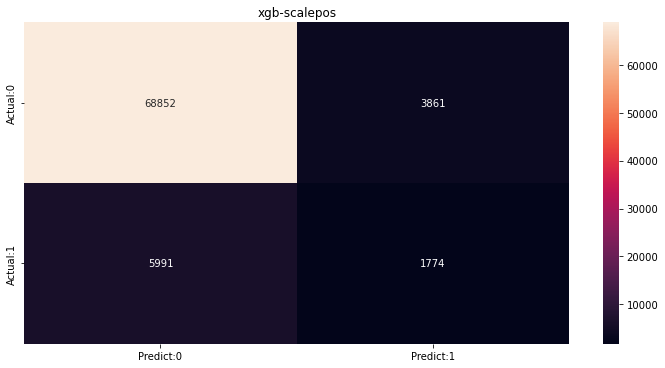

In [23]:
img_path = os.path.join(tempfile.mkdtemp(), 'imgs')

plot_metrics.plotConfusion(Yval,y_pred_val, title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
# plot_metrics.plot_roc([Yval],[y_pred_val_scores],[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_percentile([Yval],[y_pred_val_scores],bin_width=5,plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)

In [42]:
# dfTrain = df_exp[(df_exp["Year"].isin([2015,2016,2017]))&(df_exp["emptyNet"]==0)]
# dfVal = df_exp[df_exp["Year"].isin([2018])]
# Xtrain = dfTrain[features]
# Ytrain = dfTrain[label]
# Xval = dfVal[features]
# Yval = dfVal[label]


In [44]:
# Xtrain.shape

(229615, 17)

In [17]:
# experiment = "xgb-base-train-on-emptynet0"
# #obtaining default parameters by calling .fit() to XGBoost model instance
# estimator = xgb.XGBClassifier(objective='binary:logistic',
#                          enable_categorical=1,
#                           booster='gbtree',
#                           eval_metric='auc',
#                           tree_method='gpu_hist',
#                           grow_policy='lossguide',
#                           use_label_encoder=False,
#                         )
# estimator.fit(Xtrain, Ytrain.values.flatten())
# y_pred_val  = estimator.predict(Xval)
# y_pred_val_scores = estimator.predict_proba(Xval)[:,1]


# predscore_val_dict[experiment]={}
# predscore_val_dict[experiment]['val']=Yval
# predscore_val_dict[experiment]['predscore']=y_pred_val_scores



# ## Dumping model
# filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
# joblib.dump(estimator,filename)


In [18]:
# img_path = os.path.join(tempfile.mkdtemp(), 'imgs')

# plot_metrics.plotConfusion(Yval,y_pred_val, title=experiment)
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_roc([Yval],[y_pred_val_scores],[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_percentile([Yval],[y_pred_val_scores],bin_width=5,plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)

In [19]:
experiments = predscore_val_dict.keys()
Ytrues=[predscore_val_dict[experiment]['val'] for experiment in experiments]
Yscores=[predscore_val_dict[experiment]['predscore'] for experiment in experiments]
plot_labels=experiments


In [20]:
scale_pos_weight = np.sqrt(Ytrain.loc[Ytrain["isGoal"]==0].shape[0]/Ytrain.loc[Ytrain["isGoal"]==1].shape[0]) 
scale_pos_weight


3.1250506484552094

In [21]:
experiment = "xgb-scalepos"
#obtaining default parameters by calling .fit() to XGBoost model instance
estimator = xgb.XGBClassifier(objective='binary:logistic',
                         enable_categorical=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          scale_pos_weight=scale_pos_weight,
                          max_delta_step=1,
                        )
estimator.fit(Xtrain, Ytrain.values.flatten())
y_pred_val  = estimator.predict(Xval)
y_pred_val_scores = estimator.predict_proba(Xval)[:,1]


predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores



## Dumping model
filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
joblib.dump(estimator,filename)


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


['../ift6758/models/weights//xgb-scalepos-yearvalidation.pkl']

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     72713
           1       0.31      0.23      0.26      7765

    accuracy                           0.88     80478
   macro avg       0.62      0.59      0.60     80478
weighted avg       0.86      0.88      0.87     80478



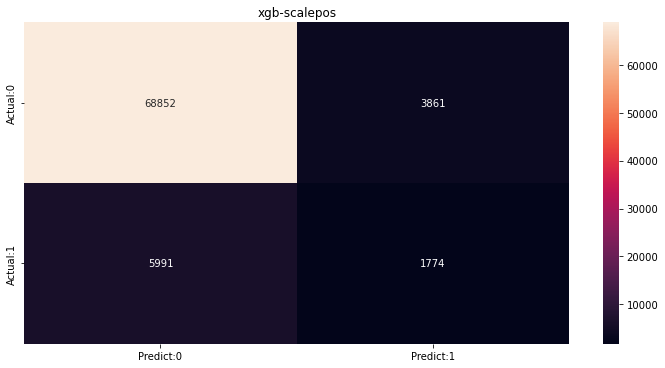

In [22]:
img_path = os.path.join(tempfile.mkdtemp(), 'imgs')

plot_metrics.plotConfusion(Yval,y_pred_val, title=experiment)
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_roc([Yval],[y_pred_val_scores],[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_percentile([Yval],[y_pred_val_scores],bin_width=5,plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)

In [24]:
experiments = predscore_val_dict.keys()
Ytrues=[predscore_val_dict[experiment]['val'] for experiment in experiments]
Yscores=[predscore_val_dict[experiment]['predscore'] for experiment in experiments]
plot_labels=experiments


In [25]:
len(Ytrues)

2

In [26]:
len(plot_labels)

2

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 432x288 with 0 Axes>

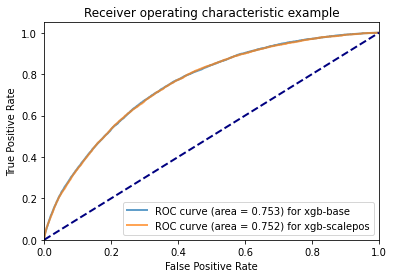

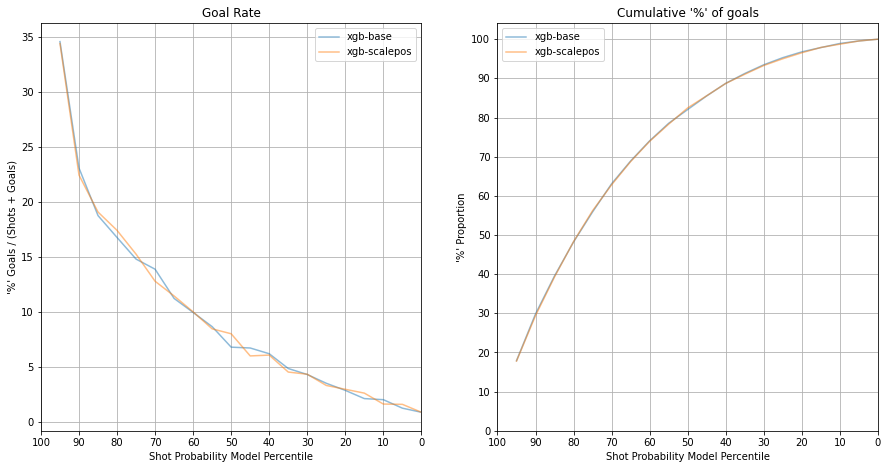

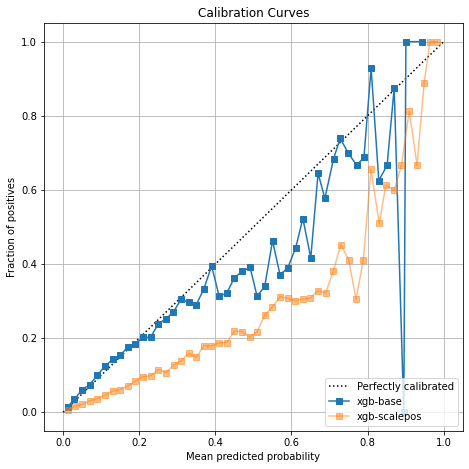

In [27]:
img_path = os.path.join(tempfile.mkdtemp(), 'imgs')

# plot_metrics.plotConfusion(Yval,y_pred_val, title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc(Ytrues,Yscores,plot_labels)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile(Ytrues,Yscores,bin_width=5,plot_labels=plot_labels)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration(Ytrues,Yscores,plot_labels,n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)

In [28]:
# To Be Done for Best Shot
### Apply XGB on features from FE2
#dictionary for collecting results
results_dict = {}
experiment = "xgbase-allfeatures"

#obtaining default parameters by calling .fit() to XGBoost model instance
xgb2 = xgb.XGBClassifier(objective='binary:logistic',
                         enable_categorical=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          scale_pos_weight=scale_pos_weight
                        )
xgb2.fit(Xtrain, Ytrain)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgb2.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgb2, scoring='roc_auc', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(Xtrain, Ytrain.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict[experiment] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'best_params': bp}


y_pred_val  = clf0.predict(Xval)
y_pred_val_scores = clf0.predict_proba(Xval)[:,1]


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgb

In [29]:

# plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
# if COMET:
#     comet_exp.log_figure(figure=plt)




In [30]:
default_params

{'objective': ['binary:logistic'],
 'use_label_encoder': [False],
 'base_score': [0.5],
 'booster': ['gbtree'],
 'colsample_bylevel': [1],
 'colsample_bynode': [1],
 'colsample_bytree': [1],
 'enable_categorical': [1],
 'gamma': [0],
 'gpu_id': [0],
 'importance_type': [None],
 'interaction_constraints': [''],
 'learning_rate': [0.300000012],
 'max_delta_step': [0],
 'max_depth': [6],
 'min_child_weight': [1],
 'missing': [nan],
 'monotone_constraints': ['()'],
 'n_estimators': [100],
 'n_jobs': [12],
 'num_parallel_tree': [1],
 'predictor': ['auto'],
 'random_state': [0],
 'reg_alpha': [0],
 'reg_lambda': [1],
 'scale_pos_weight': [3.1250506484552094],
 'subsample': [1],
 'tree_method': ['gpu_hist'],
 'validate_parameters': [1],
 'verbosity': [None],
 'eval_metric': ['auc'],
 'grow_policy': ['lossguide']}

In [31]:
from sklearn.model_selection import StratifiedKFold


In [32]:
##Hyperparameter Tuning
#creating deepcopy of default parameters before manipulations
experiment = "xgb-bayestuning-allfeatures"
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
              }

#No. of jobs
bcvj = int(np.cumsum([len(x) for x in param_grid.values()])[-1])

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgb3 = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgb3, search_spaces=param_grid, n_iter=bcvj, scoring='roc_auc', return_train_score=True, verbose=3,
                    cv = StratifiedKFold(
                            n_splits=3,
                            shuffle=True
                        ))
clf.fit(Xtrain, Ytrain.values.ravel())

#results dataframe
dfr = pd.DataFrame(clf.cv_results_)

#best parameters
bp = clf.best_params_

#storing computed values in results dictionary
results_dict[experiment] = {'iterable_parameter': np.nan,
                        'classifier': deepcopy(clf),
                        'cv_results': dfr.copy(),
                        'best_params': bp}


y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.6, max_depth=10, n_estimators=80, reg_alpha=1.6, reg_lambda=6.4;, score=(train=0.765, test=0.762) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.6, max_depth=10, n_estimators=80, reg_alpha=1.6, reg_lambda=6.4;, score=(train=0.766, test=0.756) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=51.2, learning_rate=0.6, max_depth=10, n_estimators=80, reg_alpha=1.6, reg_lambda=6.4;, score=(train=0.763, test=0.755) total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.25, max_depth=8, n_estimators=50, reg_alpha=12.8, reg_lambda=102.4;, score=(train=0.798, test=0.770) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.25, max_depth=8, n_estimators=50, reg_alpha=12.8, reg_lambda=102.4;, score=(train=0.797, test=0.764) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=3.2, learning_rate=0.25, max_depth=8, n_estimators=50, reg_alpha=12.8, reg_lambda=102.4;, score=(train=0.799, test=0.763) total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.4, learning_rate=0.7, max_depth=6, n_estimators=115, reg_alpha=6.4, reg_lambda=0.8;, score=(train=0.919, test=0.724) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.4, learning_rate=0.7, max_depth=6, n_estimators=115, reg_alpha=6.4, reg_lambda=0.8;, score=(train=0.919, test=0.723) total time=   1.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.4, learning_rate=0.7, max_depth=6, n_estimators=115, reg_alpha=6.4, reg_lambda=0.8;, score=(train=0.919, test=0.727) total time=   1.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.0, learning_rate=0.03, max_depth=10, n_estimators=65, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.776, test=0.759) total time=   2.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.0, learning_rate=0.03, max_depth=10, n_estimators=65, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.776, test=0.755) total time=   2.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.0, learning_rate=0.03, max_depth=10, n_estimators=65, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.773, test=0.762) total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2;, score=(train=0.868, test=0.752) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2;, score=(train=0.868, test=0.754) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.2, learning_rate=0.3, max_depth=6, n_estimators=100, reg_alpha=0.8, reg_lambda=0.2;, score=(train=0.866, test=0.756) total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=51.2, reg_lambda=25.6;, score=(train=0.767, test=0.760) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=51.2, reg_lambda=25.6;, score=(train=0.766, test=0.761) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=25.6, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=51.2, reg_lambda=25.6;, score=(train=0.766, test=0.759) total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.1, learning_rate=0.3, max_depth=10, n_estimators=115, reg_alpha=6.4, reg_lambda=51.2;, score=(train=0.955, test=0.745) total time=   6.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.1, learning_rate=0.3, max_depth=10, n_estimators=115, reg_alpha=6.4, reg_lambda=51.2;, score=(train=0.954, test=0.738) total time=   6.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.1, learning_rate=0.3, max_depth=10, n_estimators=115, reg_alpha=6.4, reg_lambda=51.2;, score=(train=0.956, test=0.745) total time=   6.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=200.0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.748, test=0.746) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=200.0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.747, test=0.747) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=200.0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.751, test=0.744) total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.03, max_depth=4, n_estimators=100, reg_alpha=0.8, reg_lambda=0.8;, score=(train=0.758, test=0.757) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.03, max_depth=4, n_estimators=100, reg_alpha=0.8, reg_lambda=0.8;, score=(train=0.761, test=0.749) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.03, max_depth=4, n_estimators=100, reg_alpha=0.8, reg_lambda=0.8;, score=(train=0.759, test=0.755) total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.4, learning_rate=0.2, max_depth=10, n_estimators=80, reg_alpha=3.2, reg_lambda=0.1;, score=(train=0.966, test=0.742) total time=   4.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.4, learning_rate=0.2, max_depth=10, n_estimators=80, reg_alpha=3.2, reg_lambda=0.1;, score=(train=0.965, test=0.747) total time=   4.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.4, learning_rate=0.2, max_depth=10, n_estimators=80, reg_alpha=3.2, reg_lambda=0.1;, score=(train=0.967, test=0.746) total time=   4.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=200.0, learning_rate=0.5, max_depth=6, n_estimators=50, reg_alpha=12.8, reg_lambda=3.2;, score=(train=0.749, test=0.745) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=200.0, learning_rate=0.5, max_depth=6, n_estimators=50, reg_alpha=12.8, reg_lambda=3.2;, score=(train=0.749, test=0.745) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=200.0, learning_rate=0.5, max_depth=6, n_estimators=50, reg_alpha=12.8, reg_lambda=3.2;, score=(train=0.747, test=0.746) total time=   0.3s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=51.2, reg_lambda=102.4;, score=(train=0.777, test=0.769) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=51.2, reg_lambda=102.4;, score=(train=0.780, test=0.763) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=51.2, reg_lambda=102.4;, score=(train=0.778, test=0.762) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.6, max_depth=3, n_estimators=50, reg_alpha=51.2, reg_lambda=102.4;, score=(train=0.769, test=0.757) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.6, max_depth=3, n_estimators=50, reg_alpha=51.2, reg_lambda=102.4;, score=(train=0.766, test=0.762) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.6, max_depth=3, n_estimators=50, reg_alpha=51.2, reg_lambda=102.4;, score=(train=0.767, test=0.759) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=50, reg_alpha=1.6, reg_lambda=51.2;, score=(train=0.782, test=0.766) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=50, reg_alpha=1.6, reg_lambda=51.2;, score=(train=0.780, test=0.767) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=50, reg_alpha=1.6, reg_lambda=51.2;, score=(train=0.783, test=0.760) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6;, score=(train=0.770, test=0.761) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6;, score=(train=0.767, test=0.761) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.2, max_depth=6, n_estimators=65, reg_alpha=25.6, reg_lambda=25.6;, score=(train=0.770, test=0.761) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.25, max_depth=4, n_estimators=100, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.773, test=0.765) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.25, max_depth=4, n_estimators=100, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.771, test=0.764) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.25, max_depth=4, n_estimators=100, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.773, test=0.760) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=3.2, reg_lambda=102.4;, score=(train=0.790, test=0.763) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=3.2, reg_lambda=102.4;, score=(train=0.789, test=0.765) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=100, reg_alpha=3.2, reg_lambda=102.4;, score=(train=0.788, test=0.770) total time=   1.1s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=3.2, reg_lambda=6.4;, score=(train=0.838, test=0.756) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=3.2, reg_lambda=6.4;, score=(train=0.840, test=0.756) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.4, max_depth=8, n_estimators=100, reg_alpha=3.2, reg_lambda=6.4;, score=(train=0.835, test=0.760) total time=   0.9s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.3, max_depth=8, n_estimators=130, reg_alpha=0.8, reg_lambda=102.4;, score=(train=0.834, test=0.757) total time=   1.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.3, max_depth=8, n_estimators=130, reg_alpha=0.8, reg_lambda=102.4;, score=(train=0.841, test=0.765) total time=   1.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=1.6, learning_rate=0.3, max_depth=8, n_estimators=130, reg_alpha=0.8, reg_lambda=102.4;, score=(train=0.836, test=0.763) total time=   1.3s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=102.4, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=51.2, reg_lambda=0.1;, score=(train=0.752, test=0.748) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=102.4, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=51.2, reg_lambda=0.1;, score=(train=0.752, test=0.748) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=102.4, learning_rate=0.1, max_depth=3, n_estimators=50, reg_alpha=51.2, reg_lambda=0.1;, score=(train=0.750, test=0.750) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.4, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=200.0;, score=(train=0.814, test=0.760) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.4, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=200.0;, score=(train=0.808, test=0.766) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.8, learning_rate=0.4, max_depth=6, n_estimators=65, reg_alpha=0.2, reg_lambda=200.0;, score=(train=0.811, test=0.764) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=12.8;, score=(train=0.780, test=0.769) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=12.8;, score=(train=0.783, test=0.763) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=12.8, reg_lambda=12.8;, score=(train=0.783, test=0.765) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.7, max_depth=5, n_estimators=115, reg_alpha=0.4, reg_lambda=25.6;, score=(train=0.776, test=0.761) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.7, max_depth=5, n_estimators=115, reg_alpha=0.4, reg_lambda=25.6;, score=(train=0.777, test=0.760) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.7, max_depth=5, n_estimators=115, reg_alpha=0.4, reg_lambda=25.6;, score=(train=0.776, test=0.762) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.1, max_depth=10, n_estimators=80, reg_alpha=102.4, reg_lambda=0.1;, score=(train=0.785, test=0.765) total time=   1.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.1, max_depth=10, n_estimators=80, reg_alpha=102.4, reg_lambda=0.1;, score=(train=0.787, test=0.763) total time=   1.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.8, learning_rate=0.1, max_depth=10, n_estimators=80, reg_alpha=102.4, reg_lambda=0.1;, score=(train=0.786, test=0.764) total time=   1.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.2, max_depth=12, n_estimators=130, reg_alpha=0.1, reg_lambda=0.0;, score=(train=0.992, test=0.734) total time=   6.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.2, max_depth=12, n_estimators=130, reg_alpha=0.1, reg_lambda=0.0;, score=(train=0.986, test=0.734) total time=   6.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.8, learning_rate=0.2, max_depth=12, n_estimators=130, reg_alpha=0.1, reg_lambda=0.0;, score=(train=0.985, test=0.737) total time=   6.1s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=0.1;, score=(train=0.802, test=0.766) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=0.1;, score=(train=0.801, test=0.766) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.1, max_depth=6, n_estimators=80, reg_alpha=3.2, reg_lambda=0.1;, score=(train=0.802, test=0.767) total time=   1.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=3.2, reg_lambda=6.4;, score=(train=0.834, test=0.764) total time=   1.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=3.2, reg_lambda=6.4;, score=(train=0.829, test=0.763) total time=   1.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.15, max_depth=8, n_estimators=65, reg_alpha=3.2, reg_lambda=6.4;, score=(train=0.833, test=0.766) total time=   1.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.03, max_depth=8, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6;, score=(train=0.788, test=0.760) total time=   2.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.03, max_depth=8, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6;, score=(train=0.787, test=0.765) total time=   2.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.03, max_depth=8, n_estimators=80, reg_alpha=3.2, reg_lambda=25.6;, score=(train=0.787, test=0.765) total time=   2.1s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.25, max_depth=10, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0;, score=(train=0.900, test=0.754) total time=   1.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.25, max_depth=10, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0;, score=(train=0.891, test=0.754) total time=   1.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.25, max_depth=10, n_estimators=65, reg_alpha=3.2, reg_lambda=0.0;, score=(train=0.892, test=0.756) total time=   1.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0;, score=(train=0.814, test=0.762) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0;, score=(train=0.815, test=0.763) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.25, max_depth=12, n_estimators=65, reg_alpha=3.2, reg_lambda=200.0;, score=(train=0.813, test=0.765) total time=   1.2s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8;, score=(train=0.793, test=0.763) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8;, score=(train=0.791, test=0.767) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.25, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=12.8;, score=(train=0.794, test=0.766) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.1, max_depth=10, n_estimators=115, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.788, test=0.763) total time=   1.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.1, max_depth=10, n_estimators=115, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.788, test=0.766) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.1, max_depth=10, n_estimators=115, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.786, test=0.768) total time=   1.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.787, test=0.766) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.788, test=0.765) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.2, max_depth=12, n_estimators=100, reg_alpha=12.8, reg_lambda=0.1;, score=(train=0.789, test=0.765) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.3, max_depth=15, n_estimators=130, reg_alpha=12.8, reg_lambda=12.8;, score=(train=0.787, test=0.765) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.3, max_depth=15, n_estimators=130, reg_alpha=12.8, reg_lambda=12.8;, score=(train=0.785, test=0.765) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.3, max_depth=15, n_estimators=130, reg_alpha=12.8, reg_lambda=12.8;, score=(train=0.786, test=0.763) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.6, max_depth=4, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1;, score=(train=0.776, test=0.762) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.6, max_depth=4, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1;, score=(train=0.772, test=0.759) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.6, max_depth=4, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1;, score=(train=0.776, test=0.759) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=12.8, reg_lambda=0.2;, score=(train=0.778, test=0.767) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=12.8, reg_lambda=0.2;, score=(train=0.780, test=0.761) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.1, max_depth=6, n_estimators=65, reg_alpha=12.8, reg_lambda=0.2;, score=(train=0.779, test=0.767) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.1, max_depth=15, n_estimators=150, reg_alpha=0.8, reg_lambda=200.0;, score=(train=0.781, test=0.760) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.1, max_depth=15, n_estimators=150, reg_alpha=0.8, reg_lambda=200.0;, score=(train=0.780, test=0.764) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.1, max_depth=15, n_estimators=150, reg_alpha=0.8, reg_lambda=200.0;, score=(train=0.778, test=0.769) total time=   1.3s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.5, max_depth=3, n_estimators=100, reg_alpha=12.8, reg_lambda=0.4;, score=(train=0.768, test=0.760) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.5, max_depth=3, n_estimators=100, reg_alpha=12.8, reg_lambda=0.4;, score=(train=0.765, test=0.759) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.5, max_depth=3, n_estimators=100, reg_alpha=12.8, reg_lambda=0.4;, score=(train=0.767, test=0.759) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.15, max_depth=10, n_estimators=100, reg_alpha=12.8, reg_lambda=6.4;, score=(train=0.786, test=0.763) total time=   1.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.15, max_depth=10, n_estimators=100, reg_alpha=12.8, reg_lambda=6.4;, score=(train=0.783, test=0.770) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.15, max_depth=10, n_estimators=100, reg_alpha=12.8, reg_lambda=6.4;, score=(train=0.786, test=0.763) total time=   1.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=25.6;, score=(train=0.789, test=0.764) total time=   1.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=25.6;, score=(train=0.789, test=0.763) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.2, reg_lambda=25.6;, score=(train=0.786, test=0.769) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=130, reg_alpha=0.4, reg_lambda=3.2;, score=(train=0.797, test=0.766) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=130, reg_alpha=0.4, reg_lambda=3.2;, score=(train=0.797, test=0.766) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=130, reg_alpha=0.4, reg_lambda=3.2;, score=(train=0.795, test=0.765) total time=   1.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.7, max_depth=4, n_estimators=100, reg_alpha=1.6, reg_lambda=0.8;, score=(train=0.820, test=0.755) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.7, max_depth=4, n_estimators=100, reg_alpha=1.6, reg_lambda=0.8;, score=(train=0.818, test=0.750) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=1.6, learning_rate=0.7, max_depth=4, n_estimators=100, reg_alpha=1.6, reg_lambda=0.8;, score=(train=0.825, test=0.746) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.2, max_depth=4, n_estimators=130, reg_alpha=0.8, reg_lambda=200.0;, score=(train=0.763, test=0.762) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.2, max_depth=4, n_estimators=130, reg_alpha=0.8, reg_lambda=200.0;, score=(train=0.766, test=0.757) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.2, max_depth=4, n_estimators=130, reg_alpha=0.8, reg_lambda=200.0;, score=(train=0.766, test=0.757) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.3, max_depth=5, n_estimators=65, reg_alpha=3.2, reg_lambda=102.4;, score=(train=0.787, test=0.764) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.3, max_depth=5, n_estimators=65, reg_alpha=3.2, reg_lambda=102.4;, score=(train=0.787, test=0.762) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.3, max_depth=5, n_estimators=65, reg_alpha=3.2, reg_lambda=102.4;, score=(train=0.786, test=0.768) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=102.4, reg_lambda=1.6;, score=(train=0.775, test=0.761) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=102.4, reg_lambda=1.6;, score=(train=0.775, test=0.762) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.15, max_depth=6, n_estimators=80, reg_alpha=102.4, reg_lambda=1.6;, score=(train=0.773, test=0.766) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.4;, score=(train=0.794, test=0.766) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.4;, score=(train=0.794, test=0.767) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.2, max_depth=5, n_estimators=80, reg_alpha=3.2, reg_lambda=0.4;, score=(train=0.795, test=0.763) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2;, score=(train=0.798, test=0.765) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2;, score=(train=0.794, test=0.768) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.15, max_depth=5, n_estimators=80, reg_alpha=0.0, reg_lambda=0.2;, score=(train=0.797, test=0.765) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.1, max_depth=15, n_estimators=115, reg_alpha=3.2, reg_lambda=0.4;, score=(train=0.964, test=0.758) total time=   8.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.1, max_depth=15, n_estimators=115, reg_alpha=3.2, reg_lambda=0.4;, score=(train=0.965, test=0.750) total time=   8.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.1, max_depth=15, n_estimators=115, reg_alpha=3.2, reg_lambda=0.4;, score=(train=0.966, test=0.754) total time=   8.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.0, learning_rate=0.25, max_depth=12, n_estimators=130, reg_alpha=0.2, reg_lambda=25.6;, score=(train=0.993, test=0.732) total time=  14.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.0, learning_rate=0.25, max_depth=12, n_estimators=130, reg_alpha=0.2, reg_lambda=25.6;, score=(train=0.993, test=0.737) total time=  14.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.0, learning_rate=0.25, max_depth=12, n_estimators=130, reg_alpha=0.2, reg_lambda=25.6;, score=(train=0.991, test=0.737) total time=  15.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=25.6, reg_lambda=0.4;, score=(train=0.771, test=0.762) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=25.6, reg_lambda=0.4;, score=(train=0.770, test=0.765) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.2, max_depth=12, n_estimators=65, reg_alpha=25.6, reg_lambda=0.4;, score=(train=0.772, test=0.759) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.2, max_depth=10, n_estimators=80, reg_alpha=25.6, reg_lambda=0.8;, score=(train=0.771, test=0.762) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.2, max_depth=10, n_estimators=80, reg_alpha=25.6, reg_lambda=0.8;, score=(train=0.772, test=0.759) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.2, max_depth=10, n_estimators=80, reg_alpha=25.6, reg_lambda=0.8;, score=(train=0.769, test=0.766) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.5, max_depth=15, n_estimators=65, reg_alpha=25.6, reg_lambda=0.1;, score=(train=0.767, test=0.763) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.5, max_depth=15, n_estimators=65, reg_alpha=25.6, reg_lambda=0.1;, score=(train=0.771, test=0.761) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.5, max_depth=15, n_estimators=65, reg_alpha=25.6, reg_lambda=0.1;, score=(train=0.772, test=0.758) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.25, max_depth=8, n_estimators=65, reg_alpha=25.6, reg_lambda=3.2;, score=(train=0.772, test=0.756) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.25, max_depth=8, n_estimators=65, reg_alpha=25.6, reg_lambda=3.2;, score=(train=0.768, test=0.767) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.25, max_depth=8, n_estimators=65, reg_alpha=25.6, reg_lambda=3.2;, score=(train=0.771, test=0.762) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.25, max_depth=3, n_estimators=65, reg_alpha=25.6, reg_lambda=6.4;, score=(train=0.760, test=0.760) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.25, max_depth=3, n_estimators=65, reg_alpha=25.6, reg_lambda=6.4;, score=(train=0.762, test=0.754) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.25, max_depth=3, n_estimators=65, reg_alpha=25.6, reg_lambda=6.4;, score=(train=0.762, test=0.757) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.4, max_depth=6, n_estimators=100, reg_alpha=0.0, reg_lambda=51.2;, score=(train=0.764, test=0.758) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.4, max_depth=6, n_estimators=100, reg_alpha=0.0, reg_lambda=51.2;, score=(train=0.763, test=0.758) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=51.2, learning_rate=0.4, max_depth=6, n_estimators=100, reg_alpha=0.0, reg_lambda=51.2;, score=(train=0.764, test=0.757) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.4, max_depth=5, n_estimators=80, reg_alpha=25.6, reg_lambda=25.6;, score=(train=0.766, test=0.761) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.4, max_depth=5, n_estimators=80, reg_alpha=25.6, reg_lambda=25.6;, score=(train=0.767, test=0.760) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.4, max_depth=5, n_estimators=80, reg_alpha=25.6, reg_lambda=25.6;, score=(train=0.768, test=0.759) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.25, max_depth=15, n_estimators=130, reg_alpha=6.4, reg_lambda=12.8;, score=(train=0.769, test=0.755) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.25, max_depth=15, n_estimators=130, reg_alpha=6.4, reg_lambda=12.8;, score=(train=0.765, test=0.763) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=51.2, learning_rate=0.25, max_depth=15, n_estimators=130, reg_alpha=6.4, reg_lambda=12.8;, score=(train=0.766, test=0.760) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.7, max_depth=4, n_estimators=65, reg_alpha=51.2, reg_lambda=0.2;, score=(train=0.758, test=0.756) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.7, max_depth=4, n_estimators=65, reg_alpha=51.2, reg_lambda=0.2;, score=(train=0.757, test=0.750) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=51.2, learning_rate=0.7, max_depth=4, n_estimators=65, reg_alpha=51.2, reg_lambda=0.2;, score=(train=0.756, test=0.750) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.06, max_depth=6, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6;, score=(train=0.784, test=0.765) total time=   1.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.06, max_depth=6, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6;, score=(train=0.783, test=0.767) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.06, max_depth=6, n_estimators=80, reg_alpha=0.8, reg_lambda=25.6;, score=(train=0.785, test=0.763) total time=   0.9s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=102.4;, score=(train=0.781, test=0.762) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=102.4;, score=(train=0.780, test=0.762) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.5, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=102.4;, score=(train=0.780, test=0.766) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.5, max_depth=10, n_estimators=80, reg_alpha=0.1, reg_lambda=6.4;, score=(train=0.852, test=0.756) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.5, max_depth=10, n_estimators=80, reg_alpha=0.1, reg_lambda=6.4;, score=(train=0.849, test=0.750) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.5, max_depth=10, n_estimators=80, reg_alpha=0.1, reg_lambda=6.4;, score=(train=0.860, test=0.747) total time=   1.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=6.4, reg_lambda=12.8;, score=(train=0.880, test=0.762) total time=   3.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=6.4, reg_lambda=12.8;, score=(train=0.880, test=0.763) total time=   3.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.2, learning_rate=0.15, max_depth=10, n_estimators=65, reg_alpha=6.4, reg_lambda=12.8;, score=(train=0.881, test=0.759) total time=   3.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.5, max_depth=4, n_estimators=130, reg_alpha=25.6, reg_lambda=51.2;, score=(train=0.805, test=0.762) total time=   1.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.5, max_depth=4, n_estimators=130, reg_alpha=25.6, reg_lambda=51.2;, score=(train=0.805, test=0.761) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.2, learning_rate=0.5, max_depth=4, n_estimators=130, reg_alpha=25.6, reg_lambda=51.2;, score=(train=0.807, test=0.757) total time=   0.9s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.2, max_depth=5, n_estimators=115, reg_alpha=12.8, reg_lambda=0.4;, score=(train=0.809, test=0.765) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.2, max_depth=5, n_estimators=115, reg_alpha=12.8, reg_lambda=0.4;, score=(train=0.807, test=0.764) total time=   1.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.2, learning_rate=0.2, max_depth=5, n_estimators=115, reg_alpha=12.8, reg_lambda=0.4;, score=(train=0.809, test=0.765) total time=   1.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.2, max_depth=8, n_estimators=115, reg_alpha=12.8, reg_lambda=1.6;, score=(train=0.898, test=0.754) total time=   2.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.2, max_depth=8, n_estimators=115, reg_alpha=12.8, reg_lambda=1.6;, score=(train=0.898, test=0.753) total time=   2.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.2, learning_rate=0.2, max_depth=8, n_estimators=115, reg_alpha=12.8, reg_lambda=1.6;, score=(train=0.899, test=0.757) total time=   3.0s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.15, max_depth=3, n_estimators=80, reg_alpha=6.4, reg_lambda=6.4;, score=(train=0.770, test=0.756) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.15, max_depth=3, n_estimators=80, reg_alpha=6.4, reg_lambda=6.4;, score=(train=0.765, test=0.766) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.2, learning_rate=0.15, max_depth=3, n_estimators=80, reg_alpha=6.4, reg_lambda=6.4;, score=(train=0.769, test=0.759) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


In [125]:
# clf.best_estimator_.p

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0.2,
 'gpu_id': 0,
 'interaction_constraints': '',
 'learning_rate': 0.15,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 51.2,
 'scale_pos_weight': 3.1250506484552094,
 'subsample': 1,
 'tree_method': 'gpu_hist',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'auc',
 'grow_policy': 'lossguide'}

In [37]:
experiment = "xgb-bayestuning-allfeatures"


In [38]:
df_plotly = pd.DataFrame(clf.cv_results_["params"])
ploty_hover=df_plotly.columns
df_plotly["ROC_AUC_mean_fold_test_score"]=clf.cv_results_["mean_test_score"]
df_plotly=df_plotly.reset_index().rename(columns={'index':'experiment_number'})
df_plotly["Value"]="SubOptimal"
# Ref: https://stackoverflow.com/a/34162576
df_plotly.loc[(df_plotly[list(bp)]==pd.Series(bp)).all(axis=1),"Value"]="Best"


In [39]:
import plotly.express as px

fig = px.scatter(df_plotly, y="ROC_AUC_mean_fold_test_score",color="Value", x="experiment_number",hover_data=ploty_hover,title="Scatter BayesCV Experiments Scores")
# px.scatter()
fig.update_traces(marker_size=10)
fig.show()
fig.write_html(f"../ift6758/models/{experiment}-yearvalidation.html",include_plotlyjs = 'cdn',include_mathjax ='cdn',)


## Doing Kfold CrossValidation

In [40]:
df_exp

,gameSeconds,totalGameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,isHome,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,emptyNet,Year,isGoal
0,51.0,51.0,11.0,1,Wrist Shot,10.007980,True,-55.0,6.0,34.525353,Hit,94.0,-34.0,154.275727,False,14.025066,NaN,0,2015,0
1,65.0,65.0,7.0,1,Snap Shot,0.000000,True,-79.0,0.0,10.000000,Giveaway,-37.0,-28.0,50.477718,False,7.211103,NaN,0,2015,0
2,66.0,66.0,1.0,1,Snap Shot,-4.085617,True,-75.0,-1.0,14.035669,Shot,-79.0,0.0,4.123106,True,4.123106,4.085617,0,2015,0
3,113.0,113.0,18.0,1,Wrist Shot,-46.636577,True,-55.0,-36.0,49.517674,Hit,-91.0,35.0,79.605276,False,4.422515,NaN,0,2015,0
4,157.0,157.0,5.0,1,Tip-In,-2.045408,True,-61.0,-1.0,28.017851,Faceoff,-69.0,-22.0,22.472205,False,4.494441,NaN,0,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311101,937.0,3337.0,33.0,3,Slap Shot,40.815084,True,67.0,-19.0,29.068884,Giveaway,29.0,35.0,66.030296,False,2.000918,NaN,0,2018,0
311102,993.0,3393.0,29.0,3,Wrist Shot,5.194429,False,-78.0,1.0,11.045361,Faceoff,-69.0,-22.0,24.698178,False,0.851661,NaN,0,2018,0
311103,1119.0,3519.0,19.0,3,Wrist Shot,55.007980,False,-82.0,10.0,12.206556,Missed Shot,-71.0,4.0,12.529964,False,0.659472,NaN,0,2018,0
311104,1120.0,3520.0,1.0,3,Wrist Shot,7.125016,False,-81.0,1.0,8.062258,Shot,-82.0,10.0,9.055385,True,9.055385,47.882963,0,2018,0


Fold 0
Train Years [2016, 2017, 2018] Data Points 237314
Val Years [2015]  Data Points 73792           Val ratio 0.23719246816197695


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



(73792, 1) (73792,)
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     66989
           1       0.35      0.22      0.27      6803

    accuracy                           0.89     73792
   macro avg       0.64      0.59      0.60     73792
weighted avg       0.87      0.89      0.88     73792

Fold 1
Train Years [2017, 2018, 2015] Data Points 236143
Val Years [2016]  Data Points 74963           Val ratio 0.2409564585703908


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



(74963, 1) (74963,)
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     68035
           1       0.36      0.24      0.29      6928

    accuracy                           0.89     74963
   macro avg       0.64      0.60      0.61     74963
weighted avg       0.87      0.89      0.88     74963

Fold 2
Train Years [2016, 2018, 2015] Data Points 229233
Val Years [2017]  Data Points 81873           Val ratio 0.2631675377524059


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



(81873, 1) (81873,)
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     74182
           1       0.36      0.23      0.28      7691

    accuracy                           0.89     81873
   macro avg       0.64      0.59      0.61     81873
weighted avg       0.87      0.89      0.88     81873

Fold 3
Train Years [2016, 2017, 2015] Data Points 230628
Val Years [2018]  Data Points 80478           Val ratio 0.2586835355152263


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



(80478, 1) (80478,)
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     72713
           1       0.33      0.22      0.27      7765

    accuracy                           0.88     80478
   macro avg       0.62      0.59      0.60     80478
weighted avg       0.86      0.88      0.87     80478



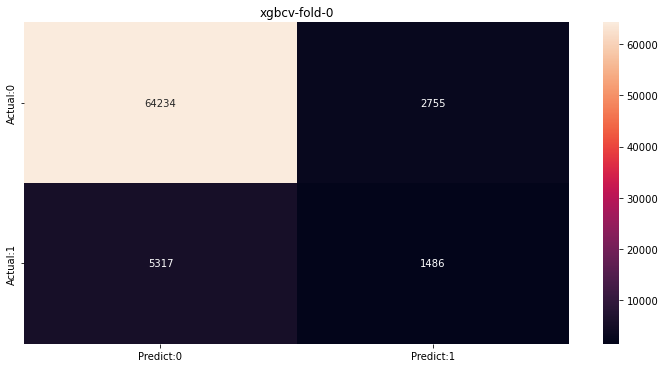

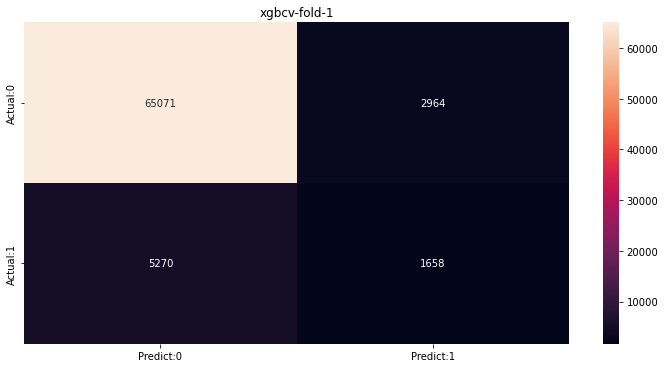

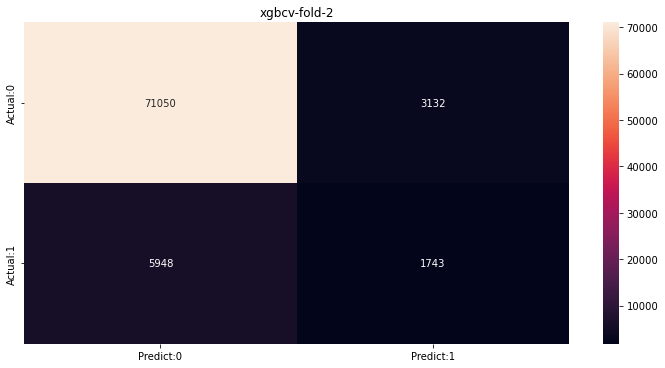

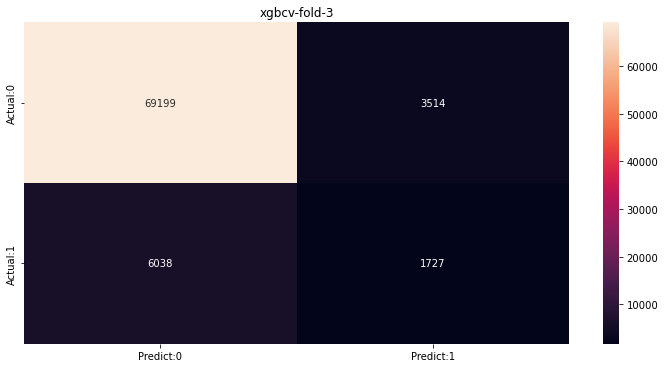

In [41]:
year_list = [2015,2016,2017,2018]
year_partitions= [[2015],[2016],[2017],[2018]]
oof = np.zeros((len(df_exp),2))

for fold_, (val_yrs) in enumerate(year_partitions):
    # if fold_!=2:
    #     continue
    trn_yrs = list(set(year_list)-set(val_yrs))
    print("Fold {}".format(fold_))

    
    trn_ids= df_exp.loc[df_exp["Year"].isin(trn_yrs)].index
    trn_idx = trn_ids.to_numpy()
    val_idx = df_exp.loc[df_exp["Year"].isin(val_yrs)].index
    np.random.shuffle(trn_idx) ##Shuffling
    print(f"Train Years {trn_yrs} Data Points {trn_idx.shape[0]}")
    print(f"Val Years {val_yrs}  Data Points {val_idx.shape[0]} \
          Val ratio {val_idx.shape[0]/(val_idx.shape[0]+trn_idx.shape[0])}")

    Xtrain, Xval = df_exp.iloc[trn_idx][features], df_exp.iloc[val_idx][features]
    ytrain, yval = df_exp.iloc[trn_idx][label], df_exp.iloc[val_idx][label],
    best_xgb_params=clf.best_estimator_.get_params()
    xgbcv = xgb.XGBClassifier(**best_xgb_params)
    xgbcv.fit(Xtrain,ytrain)
    y_pred_probs = xgbcv.predict_proba(Xval)
    y_pred_val = y_pred_probs.argmax(axis=1)
    oof[val_idx] = y_pred_probs
    print(yval.shape,y_pred_val.shape)
    experiment = f"xgbcv-fold-{fold_}"
    filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
    joblib.dump(xgbcv,filename)
    if COMET:
      comet_exp.log_model(experiment, f"{weights_dir}/{experiment}-yearvalidation.pkl")
    plot_metrics.plotConfusion(yval,y_pred_val,title=experiment)



In [146]:
a=[1,2,3]
np.random.shuffle(a)

In [147]:
a

[2, 1, 3]

In [138]:
val_idx.to_numpy()

array([    0,     1,     2, ..., 73789, 73790, 73791], dtype=int64)

In [113]:
bp

OrderedDict([('gamma', 0.2),
             ('learning_rate', 0.15),
             ('max_depth', 6),
             ('n_estimators', 65),
             ('reg_alpha', 0.1),
             ('reg_lambda', 51.2)])

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    281919
           1       0.35      0.23      0.27     29187

    accuracy                           0.89    311106
   macro avg       0.64      0.59      0.61    311106
weighted avg       0.87      0.89      0.88    311106



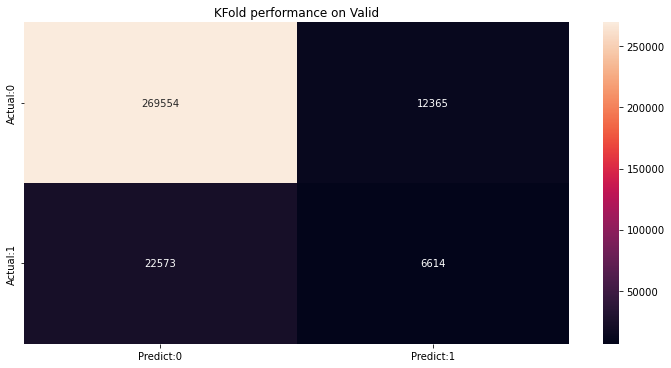

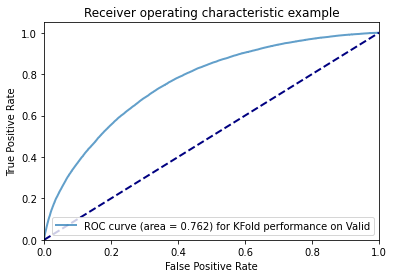

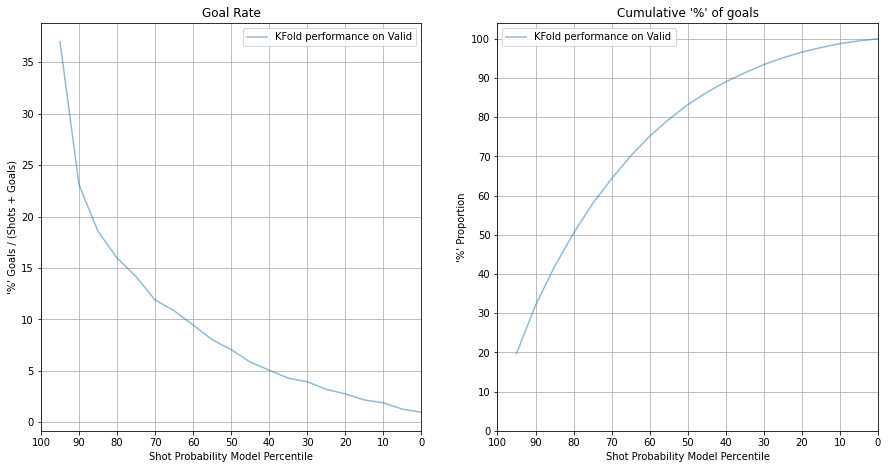

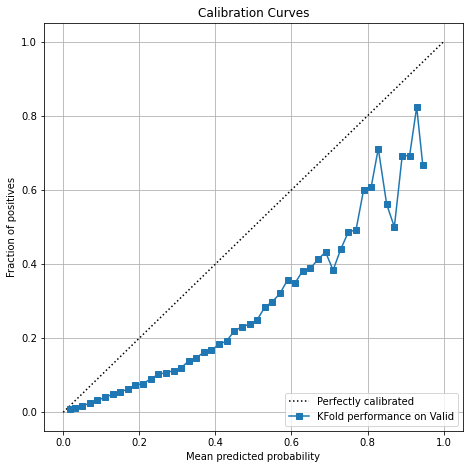

In [42]:
experiment = "KFold performance on Valid"
Yval=df_exp[label]
y_pred_val_scores = oof[:,1]
y_pred_val = oof.argmax(axis=1)
plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)




In [43]:
comet_exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/c8ebe3904da1468ea9e239c6b86569c8
COMET INFO:   Parameters:
COMET INFO:     alpha                                 : 1e-10
COMET INFO:     begin_iteration                       : 0
COMET INFO:     booster                               : gbtree
COMET INFO:     copy_X_train                          : True
COMET INFO:     cv                                    : 3
COMET INFO:     end_iteration                         : 100
COMET INFO:     error_score                           : nan
COMET INFO:     estimator                             : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=1,
              eval_metric='auc', gamma=0, gpu_id=0, gro